In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
df=pd.read_csv('time.csv',index_col='date',parse_dates=True)
df=df.iloc[:,:-1]
df['consumption'] = df['consumption'].astype(int)
df.dropna()
df.head(5)

,connection,population,actual_limit,factor,consumption
date,,,,,
2017-01-01,4037,19373,2615355,1.193640,3121791
2017-01-02,4038,19378,2616030,1.167478,3054157
2017-01-03,4039,19383,2616705,1.145279,2996857
2017-01-04,4039,19383,2616705,1.118182,2925951
2017-01-05,4040,19387,2617245,1.136099,2973448


<Axes: xlabel='date'>

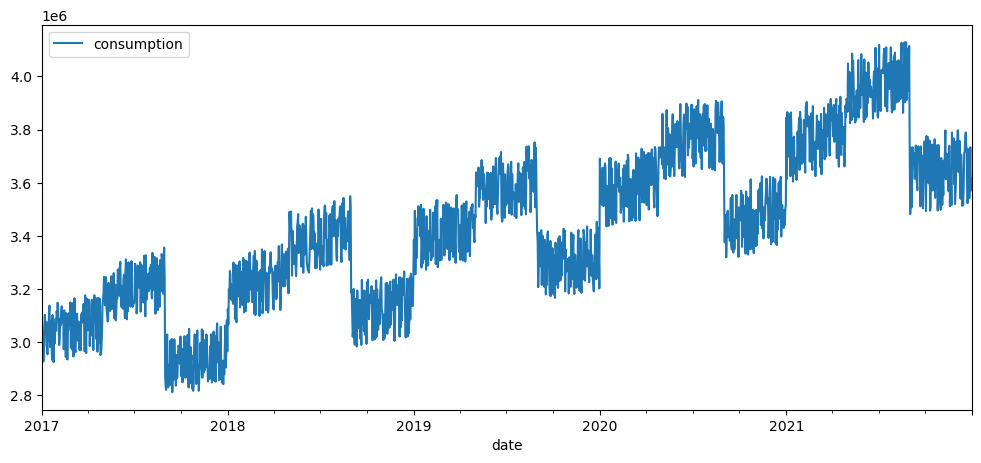

In [39]:
df[['consumption']].plot(figsize=(12,5))

In [40]:
monthly_df = df.resample('W').mean()

<Axes: xlabel='date'>

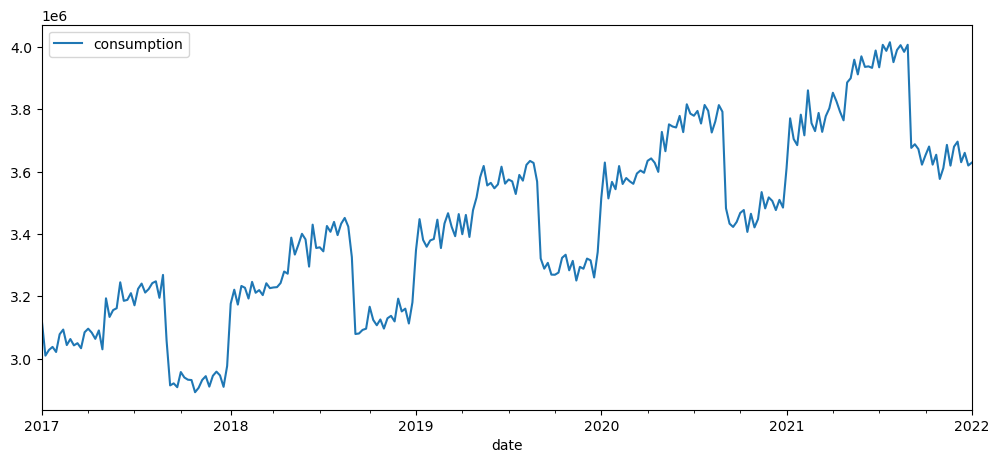

In [41]:
monthly_df[['consumption']].plot(figsize=(12,5))

In [42]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2017-01-01 to 2022-01-02
Freq: W-SUN
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   connection    262 non-null    float64
 1   population    262 non-null    float64
 2   actual_limit  262 non-null    float64
 3   factor        262 non-null    float64
 4   consumption   262 non-null    float64
dtypes: float64(5)
memory usage: 12.3 KB


In [43]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest=adfuller(dataset,autolag='AIC')
    print('ADF: ',dftest[0])
    print('P-Value: ',dftest[1])
    print('No of Lags: ',dftest[2])
    print('Num of Observation: ',dftest[3])
    print('Critical Values: ')
    for key,val in dftest[4].items():
        print("\t",key,": ",val)

In [44]:
ad_test(monthly_df['consumption'])

ADF:  -1.8998056328909345
P-Value:  0.3321525526683683
No of Lags:  1
Num of Observation:  260
Critical Values: 
	 1% :  -3.4557539868570775
	 5% :  -2.8727214497041422
	 10% :  -2.572728476331361


In [45]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(monthly_df['consumption'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6538.316, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6537.019, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6533.886, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6533.953, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6535.248, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6535.834, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6535.850, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6537.844, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6532.288, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6534.213, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6534.233, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6532.362, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6536.222, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.001 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  262
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3264.144
Date:                Sat, 16 Sep 2023   AIC                           6532.288
Time:                        14:42:30   BIC                           6539.417
Sample:                    01-01-2017   HQIC                          6535.153
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0443      0.037     -1.196      0.232      -0.117       0.028
sigma2       4.26e+09   1.05e-12   4.04e+21      0.000    4.26e+09    4.26e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.41   Jarque-Bera (JB):               387.57
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -1.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [46]:
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [47]:
train = monthly_df.iloc[:-52]
test = monthly_df.iloc[-52:]
print(train.shape,test.shape)

(210, 5) (52, 5)


In [48]:
model= SARIMAX(endog=train['consumption'],order=(1,1,0))
model2 = ARIMA(train['consumption'],order=(1,1,0))
model_fit= model.fit()
model2_fit = model2.fit()

In [49]:
plot=pd.DataFrame()
start_date = '2020-01-01'
end_date = '2020-12-30'
plot['prediction']= model_fit.predict(start=start_date, end=end_date,dynamic=True)
plot['prediction2']=model2_fit.predict(start=start_date, end=end_date,dynamic=True)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'